#### Testeo Modelos 
En este sección vamos a realizar testeos de los diferentes modelos que se guardaron.

Recorda que hicimos entrenamiento por separado. Por un lado tenemos un entrenamiento basado solo en 
latitudes y longitudes, es decir un modelo de predicción de latitudes y longitudes, y por otro lado se tiene un modelo dedicado solo a la prediccion de las alturas. 

In [18]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import utils_nn as utlnn

In [19]:
x_test = pd.read_csv("./Train_Test/x_test.csv")
y_test = pd.read_csv("./Train_Test/y_test.csv")

In [20]:
autoencoder_Lat_Lon = tf.keras.models.load_model('modelos_entrenamiento/modelos_latitudes_longitudes/entrenamiento_lat_lon_600_120.keras')
autoencoder_Height = tf.keras.models.load_model('modelos_entrenamiento/entrenamiento_alturas2.keras')

In [21]:
# Predecimos una muestra en particular de mi df
idx = 1 
#=====Latitudes Longitudes=====
# y_pred_lat_lon = autoencoder_Lat_Lon.predict(np.expand_dims(x_test.iloc[idx], axis = 0))
y_true =y_test.iloc[idx]
# # Separamos Latitudes Longitudes
y_true_latitudes = y_true[0:100]
y_true_longitudes = y_true[100:200]
# y_pred_latitudes = y_pred_lat_lon[0,0:100]
# y_pred_longitudes = y_pred_lat_lon[0,100:200]
lat_pred, lon_pred = autoencoder_Lat_Lon.predict(np.expand_dims(x_test.iloc[idx], axis = 0))

lat_pred=lat_pred.flatten()
lon_pred = lon_pred.flatten()

#====== Alturas =======
y_pred_heights = autoencoder_Height.predict(np.expand_dims(x_test.iloc[idx], axis = 0))
y_pred_heights = y_pred_heights[0,0:100]
y_true_heights = y_true[200:300]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


In [22]:
print(lat_pred)

[-42.410103 -42.368847 -42.339546 -42.333843 -42.516666 -42.560436
 -42.31015  -42.33539  -42.418854 -42.356075 -42.328842 -42.206688
 -42.337944 -42.370777 -42.36081  -42.33542  -42.322655 -42.241867
 -42.244484 -42.258488 -42.04277  -42.231243 -42.212708 -42.322956
 -42.373394 -42.210236 -42.33066  -42.188175 -42.125362 -42.090324
 -42.10433  -42.047295 -41.949604 -42.12108  -41.83522  -41.963116
 -41.88029  -41.83536  -41.98066  -41.770466 -41.752296 -41.96385
 -41.73396  -41.737663 -41.76435  -41.674107 -41.48753  -41.539997
 -41.575512 -41.56748  -41.647213 -41.46978  -41.213528 -41.479927
 -41.489998 -41.24078  -41.310783 -41.23617  -41.02715  -41.132824
 -41.283886 -41.036198 -40.958405 -40.903973 -40.9633   -40.92194
 -40.73091  -40.746956 -40.865234 -40.75759  -40.806736 -40.50968
 -40.60407  -40.567894 -40.501026 -40.54309  -40.43235  -40.464325
 -40.39007  -40.100956 -40.27548  -40.14987  -40.10277  -40.141315
 -39.933727 -40.11212  -39.855854 -39.69075  -39.99718  -39.78936

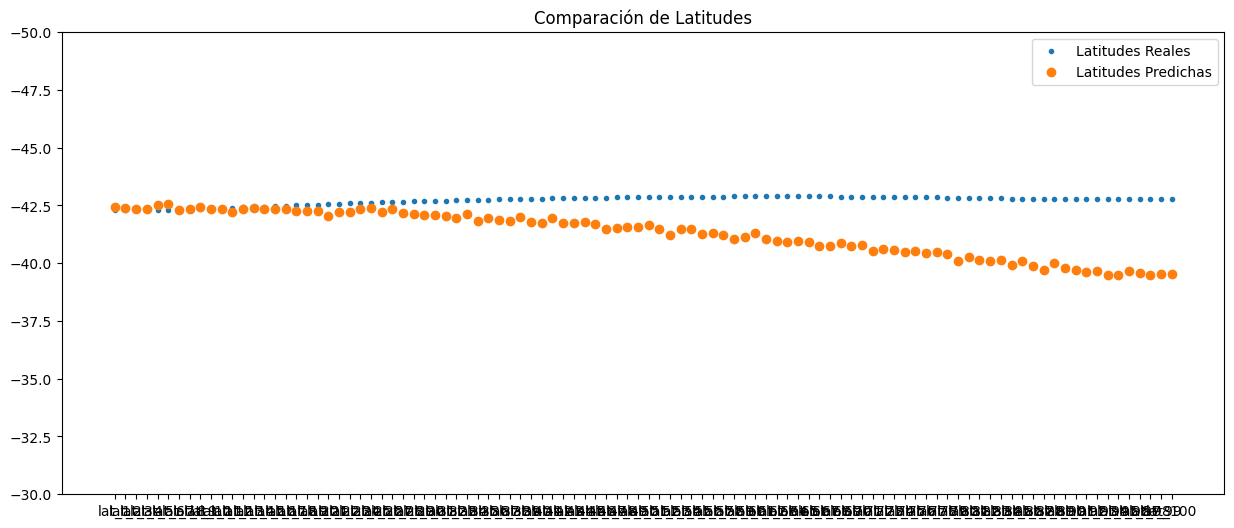

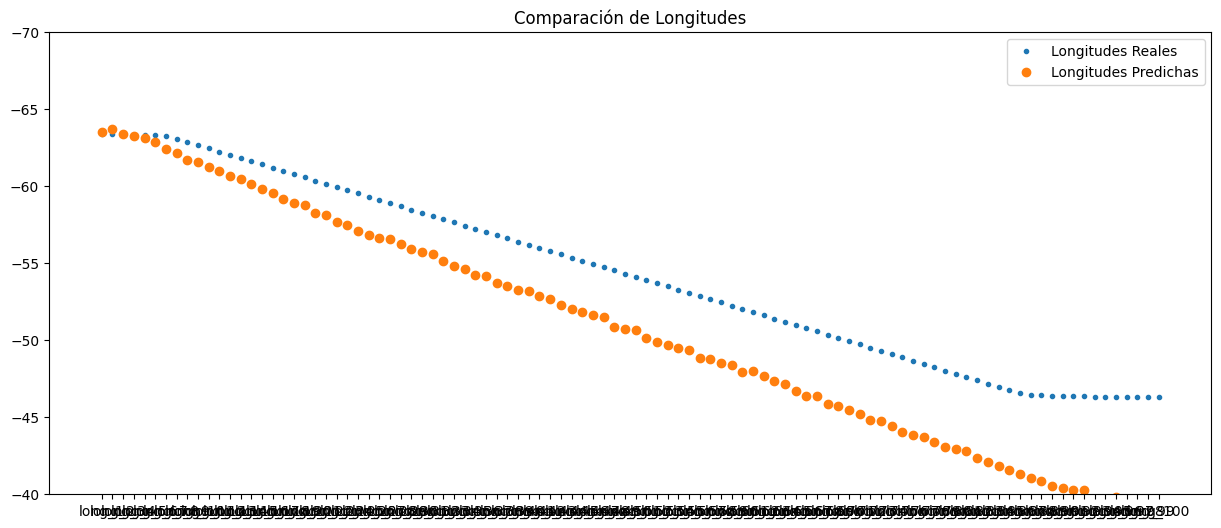

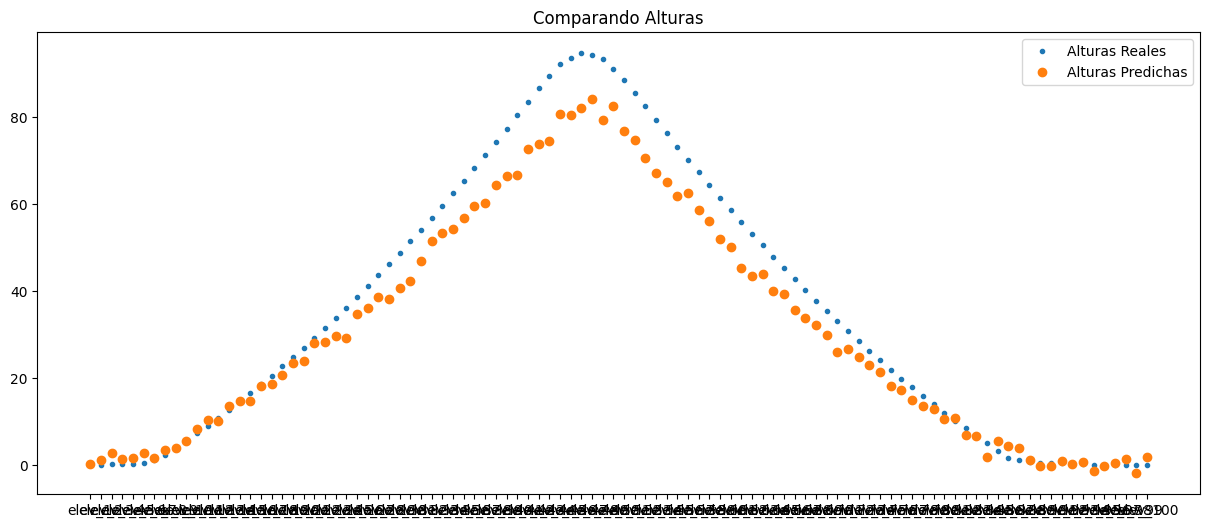

In [23]:
# Grafica Latitudes 
plt.figure(figsize = (15,6))
plt.plot(y_true_latitudes, label = 'Latitudes Reales', linestyle = 'None', marker = '.')
# plt.plot(y_pred_latitudes, label = 'Latitudes Predichas', linestyle = 'None', marker = 'o')
plt.plot(lat_pred, label = 'Latitudes Predichas', linestyle = 'None', marker = 'o')
plt.ylim(-30,-50)
plt.title('Comparación de Latitudes')
plt.legend()
plt.show()

# Graf. Longitudes
plt.figure(figsize=(15,6))
plt.plot(y_true_longitudes,label= 'Longitudes Reales', linestyle = 'None',marker= '.')
# plt.plot(y_pred_longitudes,label= 'Longitudes Predichas', linestyle = 'None', marker = 'o')
plt.plot(lon_pred,label= 'Longitudes Predichas', linestyle = 'None', marker = 'o')
plt.ylim(-40,-70)
plt.title("Comparación de Longitudes")
plt.legend()
plt.show()

# Graf. Alturas
plt.figure(figsize=(15,6))
plt.plot(y_true_heights, label = "Alturas Reales",linestyle= 'None', marker = '.')
plt.plot(y_pred_heights, label = "Alturas Predichas", linestyle = 'None', marker = 'o')
plt.title("Comparando Alturas")
plt.legend()
plt.show()

## Errores 
1. Error de manera individual:
  * Puedo calcular $d_{2D}$ usando **geopy.distance.geodesic**.
  * Luego calcular la diferencia de alturas $\Delta z$
  * Finalmente usar un $d_{3D} = \sqrt{(d_{2D})^2 + (\Delta z)^2}$ y así obtendría mi distancia en 3D.
2. ECM
  * Para obtener el Error Cuadrático Medio puedo, sumar los valores y dividir por la cantidad de puntos (100 puntos)
3. RECM(RMSE)
  * Por último se podría tomar la raiz del ECM para expresar el error promedio en metros.

In [ ]:
# Distance_havers = utlnn.haversine_distance(y_true_latitudes,y_true_longitudes,y_pred_latitudes,y_pred_longitudes)
Distance_havers = utlnn.haversine_distance(y_true_latitudes,y_true_longitudes,lat_pred,lon_pred)

NameError: name 'y_pred_latitudes' is not defined

In [ ]:
plot = False
# Calculamos el error 
error = np.sum(Distance_havers**2)/len(Distance_havers)
print("Raiz del ECM:",np.sqrt(error))

if plot == True:
  plt.figure(figsize=(15,6))
  plt.bar(range(len(Distance_havers)), Distance_havers, color='skyblue')
  plt.xlabel('Índice')
  plt.ylabel('Error (distancia)')
  plt.title('Errores como distancias')
  plt.show()

NameError: name 'Distance_havers' is not defined

In [ ]:
distance = utlnn.distances_by_geodesic(y_true_latitudes,y_true_longitudes,y_pred_latitudes,y_pred_longitudes) #Km
print(f"distancia 2D: {distance[99]}")
sq_distance = distance**2
error_2d = np.sum(sq_distance)/len(sq_distance) #ECM
sqrt_error_2d = np.sqrt(error_2d)
print("Raiz del error ECM:",sqrt_error_2d)


distancia 2D: 162.52372712087538
Raiz del error ECM: 101.19341428953206


In [ ]:
plot1 = False
if plot1 == True:
  plt.figure(figsize=(15,6))
  plt.bar(range(len(distance)), distance, color='skyblue')
  plt.xlabel('Índice')
  plt.ylabel('Error (distancia)')
  plt.title('Errores como distancias 3D Km')
  plt.show()

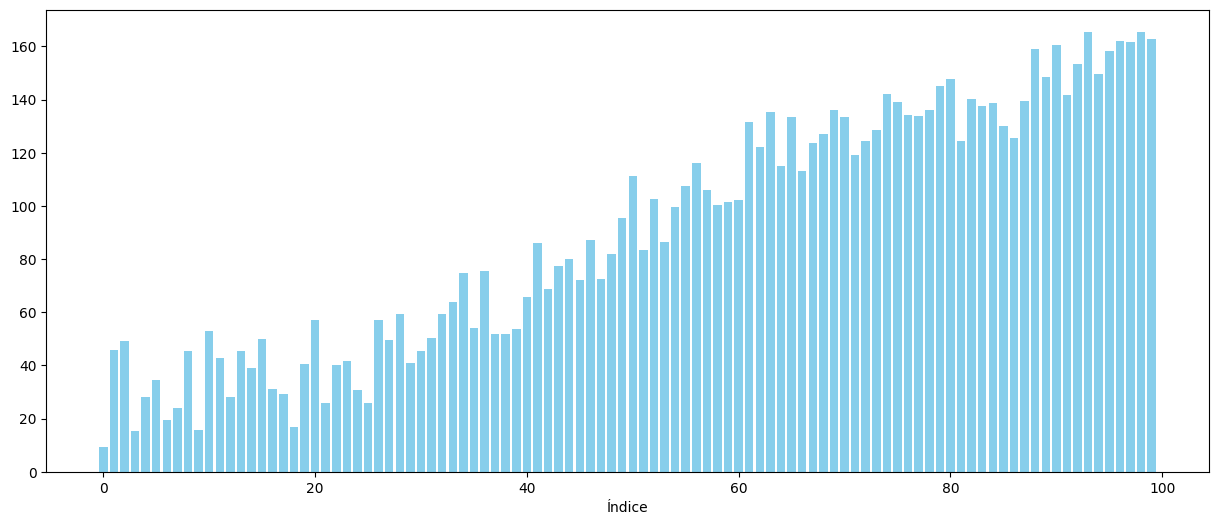

In [ ]:
distance_3d = utlnn.distances_3D(distance,y_true_heights,y_pred_heights)   
plt.figure(figsize=(15,6))
plt.bar(range(len(distance_3d)), distance_3d, color='skyblue')
plt.xlabel('Índice')
plt.show()